In [669]:
import numpy as np
import requests
import json
import pandas as pd
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
cv = CountVectorizer()
nltk.download("stopwords")
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

stop_words.add('module')
stop_words.add('section')
stop_words.add('learning')
stop_words.add('objective')
stop_words.add('description')
stop_words.add('instructor')
stop_words.add('lp')
stop_words.add('also')
stop_words.add('understanding')
stop_words.add('end')
stop_words.add('youll')
stop_words.add('well')
stop_words.add('including')

[nltk_data] Downloading package stopwords to /Users/dpapp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dpapp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [670]:
url = 'http://localhost:4000/graphql'

# Get all the modules in the DB and convert it to a dataframe

In [697]:
moduleData = requests.post(url, json={'query': '{ module(input:{}){id, name, hours, objectives, description} }'}).json()

print(len(moduleData.get('data').get('module')))

18


In [672]:
moduleDF = pd.DataFrame(moduleData.get('data').get('module'))

moduleDF.head()

,id,name,hours,objectives,description
0,644827afc3faa4c9ea96a800,Linear Regression,0.75,"[Linear Regression, Correlation, Regression An...",This module is designed to introduce students ...
1,64496079d5fb014e40d5ea39,Statistical Analysis,1.50,"[Statistical Analysis, Descriptive Statistics,...",This module is designed to teach students the ...
2,644960add5fb014e40d5ea3a,Logarithms,2.00,"[Logarithms, Exponential Functions, Logarithmi...",This module is designed to introduce students ...
3,644960bcd5fb014e40d5ea3b,Arithmetics,0.50,"[Arithmetic, Operations, Addition, Subtraction...",This module is designed to teach students the ...
4,64496111d5fb014e40d5ea3c,Euclidean distance,2.25,"[Euclidean Distance, Distance Formula, Pythago...","In this module, we'll be learning about the Eu..."


# Get all the sections in the DB and convert it to a dataframe

In [673]:
sectionData = requests.post(url, json={'query': '{ section(input:{}){id, sectionName, description, intro, keywords, objectives} }'}).json()

print(json.dumps(sectionData.get('data').get('section'), indent=2))

[
  {
    "id": "64480fd85ee3f93a77784aeb",
    "sectionName": "Course Introduction and Design",
    "description": "Assess the effectiveness of your past, current, and future projects based on universal success factors and global contingency considerations,  Intelligently evaluate projects for inclusion, and continued investment, in an organization\u2019s portfolio,  Revise project plans to accommodate time and resource conflicts, Evaluate project performance based on a balanced set of key performance indicators, Apply critical thinking to assess project situations and devise appropriate tactical and strategic responses, Present yourself to a potential employer as someone who is capable of leading projects",
    "intro": "",
    "keywords": [
      "expectations",
      "management",
      "conceptual"
    ],
    "objectives": [
      "Discuss high level and integration of topics in course design",
      "Understand conceptual approach to treatment of project management",
      "Recog

In [674]:
sectionDF = pd.DataFrame(sectionData.get('data').get('section'))

sectionDF.head()

,id,sectionName,description,intro,keywords,objectives
0,64480fd85ee3f93a77784aeb,Course Introduction and Design,"Assess the effectiveness of your past, current...",,"[expectations, management, conceptual]",[Discuss high level and integration of topics ...
1,64492dab53da498461a3e3c1,Test 2,Some wise words,Wise words,[],[]
2,645116ec2a4785d4b7799759,Section 1,"In this module, we introduce to the area of Op...",,[],[]
3,645116f22a4785d4b779975a,Section 2,"In this module, we introduce the area of Linea...",,[],[]
4,645116f62a4785d4b779975b,Section 3,,,[],[]


# Merge all the text content into a single column for each module

This is an essential step to be able to perform the text analysis and text vectorization on the data

In [675]:
def scalar_to_str(df):
    lst_o = list(df['objectives'])

    string_obj_feature = ''

    for obj in lst_o:
        string_obj_feature += obj + ' '

    df['objectives'] = string_obj_feature
    return df

moduleDF = moduleDF.apply(scalar_to_str, axis=1)

In [676]:
moduleDF['feature'] = moduleDF['name'] + ' ' + moduleDF['objectives'] + ' ' + moduleDF['description']

moduleDF.drop(['name', 'objectives', 'description'], axis=1, inplace=True)

moduleDF.head()

,id,hours,feature
0,644827afc3faa4c9ea96a800,0.75,Linear Regression Linear Regression Correlatio...
1,64496079d5fb014e40d5ea39,1.50,Statistical Analysis Statistical Analysis Desc...
2,644960add5fb014e40d5ea3a,2.00,Logarithms Logarithms Exponential Functions Lo...
3,644960bcd5fb014e40d5ea3b,0.50,Arithmetics Arithmetic Operations Addition Sub...
4,64496111d5fb014e40d5ea3c,2.25,Euclidean distance Euclidean Distance Distance...


In [677]:
def _text_processing(col: pd.DataFrame()):
    column = col.str.lower()
    column = column.str.replace("[^a-z ]", "")
    word_tokens = column.str.split()
    keys = word_tokens.apply(
        lambda x: [item for item in x if item not in stop_words]
    )
    for i in range(len(keys)):
        keys[i] = " ".join(keys[i])
        column = keys
    return column

In [678]:
moduleDF['cleaned_feature'] = _text_processing(moduleDF['feature'])

/var/folders/tp/4mcknzvj6zj5kcx78g7f5nmw0000gp/T/ipykernel_14878/2961858478.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  column = column.str.replace("[^a-z ]", "")


In [679]:
moduleDF.head()

,id,hours,feature,cleaned_feature
0,644827afc3faa4c9ea96a800,0.75,Linear Regression Linear Regression Correlatio...,linear regression linear regression correlatio...
1,64496079d5fb014e40d5ea39,1.50,Statistical Analysis Statistical Analysis Desc...,statistical analysis statistical analysis desc...
2,644960add5fb014e40d5ea3a,2.00,Logarithms Logarithms Exponential Functions Lo...,logarithms logarithms exponential functions lo...
3,644960bcd5fb014e40d5ea3b,0.50,Arithmetics Arithmetic Operations Addition Sub...,arithmetics arithmetic operations addition sub...
4,64496111d5fb014e40d5ea3c,2.25,Euclidean distance Euclidean Distance Distance...,euclidean distance euclidean distance distance...


In [680]:
def get_tokens(text):
    payload = ""

    tokens = word_tokenize(text)

    tokens = [t for t in tokens if not t in stop_words]

    for token in tokens:
        payload += token + ' '

    return payload

In [681]:
moduleDF['tokens'] = moduleDF['cleaned_feature'].apply(lambda x: get_tokens(x))

moduleDF.head()

,id,hours,feature,cleaned_feature,tokens
0,644827afc3faa4c9ea96a800,0.75,Linear Regression Linear Regression Correlatio...,linear regression linear regression correlatio...,linear regression linear regression correlatio...
1,64496079d5fb014e40d5ea39,1.50,Statistical Analysis Statistical Analysis Desc...,statistical analysis statistical analysis desc...,statistical analysis statistical analysis desc...
2,644960add5fb014e40d5ea3a,2.00,Logarithms Logarithms Exponential Functions Lo...,logarithms logarithms exponential functions lo...,logarithms logarithms exponential functions lo...
3,644960bcd5fb014e40d5ea3b,0.50,Arithmetics Arithmetic Operations Addition Sub...,arithmetics arithmetic operations addition sub...,arithmetics arithmetic operations addition sub...
4,64496111d5fb014e40d5ea3c,2.25,Euclidean distance Euclidean Distance Distance...,euclidean distance euclidean distance distance...,euclidean distance euclidean distance distance...


In [682]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(moduleDF['tokens'])

In [683]:
X.toarray()

array([[0.04222673, 0.        , 0.        , ..., 0.        , 0.        ,
        0.05792077],
       [0.05087903, 0.        , 0.        , ..., 0.        , 0.        ,
        0.0697888 ],
       [0.04497521, 0.        , 0.        , ..., 0.        , 0.        ,
        0.06169075],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [684]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)

kmeans.fit(X)

clusters = kmeans.labels_

In [685]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, random_state=42)

reduced_features = pca.fit_transform(X.toarray())

x0 = reduced_features[:, 0]
x1 = reduced_features[:, 1]

In [686]:
moduleDF['cluster'] = clusters
moduleDF['x0'] = x0
moduleDF['x1'] = x1

In [688]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score

get_top_keywords(10)


Cluster 0
sciences,data,linear,testing,hypothesis,statistics,students,analysis,statistical,regression

Cluster 1
optimization,integer,applications,theory,modeling,problem,video,management,models,programming

Cluster 2
theorem,product,vector,vectors,dimensions,spaces,pythagorean,space,euclidean,distance

Cluster 3
equations,students,mathematical,decay,growth,properties,logarithmic,exponential,functions,logarithms

Cluster 4
combined,carlo,business,calculate,margin,profit,costs,leverage,analysis,breakeven

Cluster 5
surplus,programming,minimization,maximization,constraints,function,problem,method,variables,graphical

Cluster 6
arithmetics,improve,mathematical,skills,decimals,percentages,fractions,students,operations,arithmetic

Cluster 7
irregular,simplex,computer,cutting,programming,branch,problem,solutions,method,problems

Cluster 8
problems,topic,changes,model,models,computer,new,parameters,analysis,sensitivity

Cluster 9
robust,input,metafrontier,modeling,different,factors,analysis,

In [689]:
cluster_map = {
    0: 'Introduction to Operational Research',
    1: 'Linear Programming Model Formulation and Graphical Solutions',
    2: 'Computer Solutions for Linear Programming Formulation',
    3: 'Linear Programming Modeling Applications',
    4: "Data Envelopment Analysis",
    5: "Integer Programming",
    6: "Transportation, Transshipment and Assignment",
    7: "Network Flow Models",
    8: "Introduction to Nonlinear Programming",
    9: "Operation Scheduling",
}

moduleDF['cluster'] = moduleDF['cluster'].map(cluster_map)

In [695]:
moduleDF.head(20)

,id,hours,feature,cleaned_feature,tokens,cluster,x0,x1
0,644827afc3faa4c9ea96a800,0.750,Linear Regression Linear Regression Correlatio...,linear regression linear regression correlatio...,linear regression linear regression correlatio...,Introduction to Operational Research,-0.378784,-0.341276
1,64496079d5fb014e40d5ea39,1.500,Statistical Analysis Statistical Analysis Desc...,statistical analysis statistical analysis desc...,statistical analysis statistical analysis desc...,Introduction to Operational Research,-0.478950,-0.341825
2,644960add5fb014e40d5ea3a,2.000,Logarithms Logarithms Exponential Functions Lo...,logarithms logarithms exponential functions lo...,logarithms logarithms exponential functions lo...,Linear Programming Modeling Applications,-0.302021,-0.113140
3,644960bcd5fb014e40d5ea3b,0.500,Arithmetics Arithmetic Operations Addition Sub...,arithmetics arithmetic operations addition sub...,arithmetics arithmetic operations addition sub...,"Transportation, Transshipment and Assignment",-0.364423,-0.220034
4,64496111d5fb014e40d5ea3c,2.250,Euclidean distance Euclidean Distance Distance...,euclidean distance euclidean distance distance...,euclidean distance euclidean distance distance...,Computer Solutions for Linear Programming Form...,-0.294258,-0.154582
5,645117a52a4785d4b779975d,0.250,Introduction Operational Research Optimization...,introduction operational research optimization...,introduction operational research optimization...,Linear Programming Model Formulation and Graph...,-0.081770,0.365363
6,645117b32a4785d4b779975e,0.200,"Definition, History, and Applications Linear P...",definition history applications linear program...,definition history applications linear program...,Linear Programming Model Formulation and Graph...,0.308773,0.131823
7,645117bf2a4785d4b779975f,0.300,Operational Research Modeling Data Envelopment...,operational research modeling data envelopment...,operational research modeling data envelopment...,Operation Scheduling,-0.198544,0.318299
8,645117ca2a4785d4b7799760,0.275,Break-Even Analysis Break-Even Analysis Cost-V...,breakeven analysis breakeven analysis costvolu...,breakeven analysis breakeven analysis costvolu...,Data Envelopment Analysis,-0.303398,-0.059160
9,64511ab2f9ce74323575fff7,0.300,Linear Programming (LP) Modeling Linear Progra...,linear programming modeling linear programming...,linear programming modeling linear programming...,Linear Programming Model Formulation and Graph...,-0.012159,0.457933


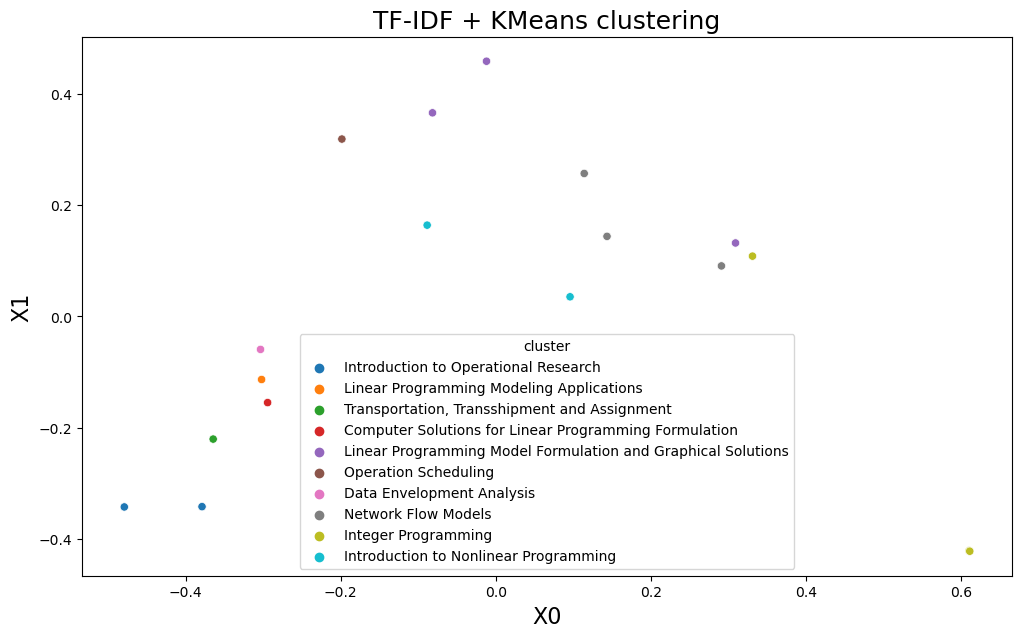

In [691]:
from matplotlib import pyplot as plt
import seaborn as sns

# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=moduleDF, x='x0', y='x1', hue='cluster', palette="tab10")
plt.show()

In [692]:
# sum the number of hours for each cluster
moduleDF.groupby('cluster')['hours'].sum()

cluster
Computer Solutions for Linear Programming Formulation           2.250
Data Envelopment Analysis                                       0.275
Integer Programming                                             0.900
Introduction to Nonlinear Programming                           0.600
Introduction to Operational Research                            2.250
Linear Programming Model Formulation and Graphical Solutions    0.750
Linear Programming Modeling Applications                        2.000
Network Flow Models                                             0.900
Operation Scheduling                                            0.300
Transportation, Transshipment and Assignment                    0.500
Name: hours, dtype: float64

<AxesSubplot:xlabel='cluster'>

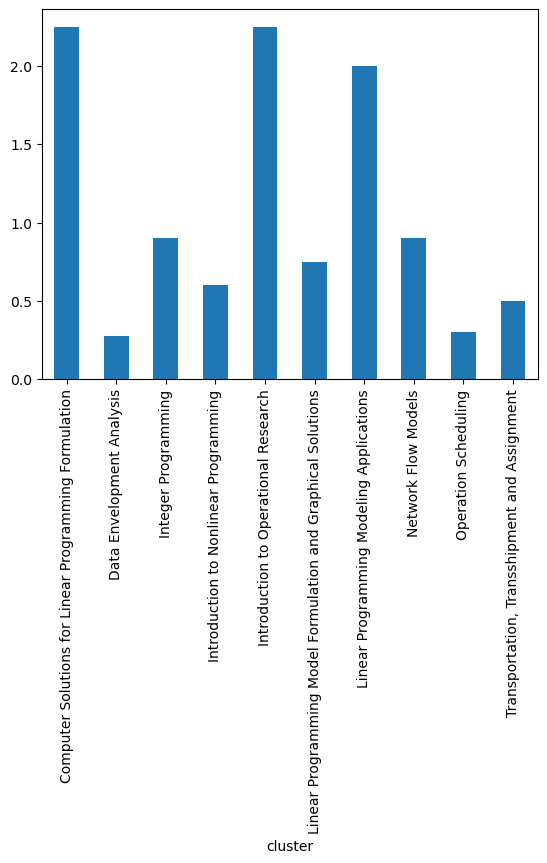

In [693]:
moduleDF.groupby('cluster')['hours'].sum().plot(kind='bar')